# Processing of the results

First some imports

In [4]:
import os

from gravann.input import csv_reader
from gravann.functions import unit_conversion

from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import ast
import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Processing and Data Visualization

In [5]:
sample = "churyumov-gerasimenko"
output_directory = Path(f"./results/{sample}")
error_of_interest = "relRMSE"
input_csv_file = output_directory.joinpath(f"total_results_{sample}.csv")

one_km = unit_conversion.convert_altitude(sample, np.array([1.0]), forward=False, unit='km')[0]


noise_replacement = {
    "['']" : "No Noise",
    "['constant_bias', [0.000272, 0.0, 0.0]]": "Constant Bias $c = 0.000272$",
    "['gaussian', 0.0, 0.146731]": "Additive Gaussian $\mu = 0 \; \sigma= 0.14$",
    "['gaussian', 0.0, 1.467314]": "Additive Gaussian $\mu = 0 \; \sigma= 1.47$",
    "['adaptive_gaussian_noise', 0.001]": "Multiplicative Gaussian $\mu = 1 \; \sigma= 0.001$",
    "['adaptive_gaussian_noise', 0.01]": "Multiplicative Gaussian $\mu = 1 \; \sigma= 0.01$",
    "['adaptive_gaussian_noise', 0.1]": "Multiplicative Gaussian $\mu = 1 \; \sigma= 0.1$"
}

sample_distance_replacement = {
    "[0. 1.]": "$(0, 1)$",
    "[1. 3.]": "$(1, 3)$",
    "[3. 5.]": "$(3, 5)$",
}

In [17]:
df = pd.read_csv(input_csv_file)
ALTITUDES = ast.literal_eval(df.at[0, "validation_sampling_altitudes"])
str_altitudes = [str(x) for x in ALTITUDES]
df = df[df["noise"] != "['combined', 0.0, 0.146731, [0.000272, 0.0, 0.0]]"]
df = df[df["noise"] != "['combined', 0.0, 1.467314, [0.000272, 0.0, 0.0]]"]
df["sample_domain"] = df["sample_domain"].apply(lambda x: str(x))
df = df[(df["iterations"] == 10000) & (df["pretrained_model"] == "None") & (df["resolution"] == "100%") & (df["noise"] == "['']") & (df["sample_domain"] == "[0.0, 1.0]") & (df["integration_points"] == 300000)]

interesting_columns = ["sample", "pretrained_model", "seed", "ground_truth", "resolution", "sample_domain", "noise", "iterations", "integration_points"]
interesting_columns.extend([col for col in df if col.startswith(error_of_interest)])
interesting_columns = [x for x in interesting_columns if "@High Altitude" not in x and "@Low Altitude" not in x]

df = df[interesting_columns]

unit_conversion.convert_pandas_altitudes(df, ALTITUDES, convert_height=False, only_height=True)
df.drop(columns=["sample", "pretrained_model", "seed", "resolution", "sample_domain", "noise", "integration_points", "iterations"], inplace=True)

In [18]:
df.groupby(["ground_truth"]).mean()

,0.001,0.005,0.01,0.05,0.1,0.5,1.0,5.0,10.0,50.0
ground_truth,,,,,,,,,,
mascon,0.061507,0.036389,0.022287,0.004487,0.002169,0.000877,0.000569,0.000050,0.000025,0.000005
polyhedral,0.058438,0.041732,0.022997,0.003187,0.001138,0.000740,0.000629,0.000056,0.000029,0.000006


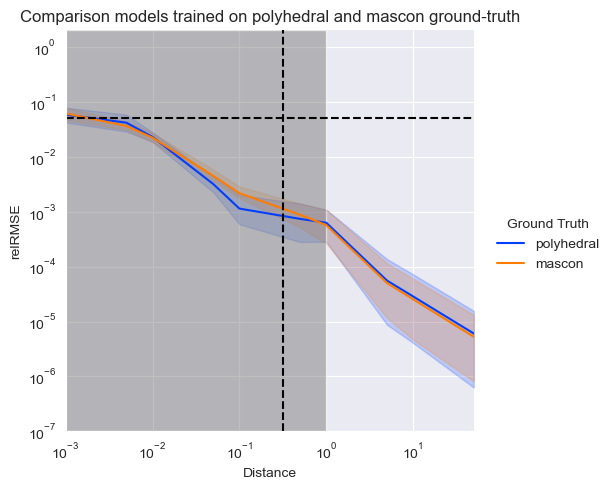

In [4]:
dfm = df.melt(["ground_truth"], str_altitudes, var_name="Distance", value_name=error_of_interest)
dfm["Distance"] = dfm["Distance"].apply(lambda x: float(x))
dfm[error_of_interest] = dfm[error_of_interest].apply(lambda x: float(x))
dfm.rename(columns={"ground_truth": "Ground Truth"}, inplace=True)

g = sns.relplot(
    data=dfm, kind="line",
    x="Distance", y=error_of_interest,
    hue="Ground Truth", palette="bright", hue_order=["polyhedral", "mascon"]
)
g.set(
    xlim=(0.001, 50.0), xscale='log', yscale='log', ylim=(1e-7, 2.0),
    title="Comparison models trained on polyhedral and mascon ground-truth",
)


g.map(plt.axhline, y=0.05, ls='--', c='black', label="5%")
g.map(plt.axvline, x=one_km, ls='--', c='black', label="1 km")

for ax in g.axes[:,0]:
    ax.axvspan(0, 1.0, facecolor='gray', alpha=0.5)


g.tight_layout()
save_path = os.path.join(output_directory, f"{sample}_{error_of_interest}_mascon_polyhedral.png")
g.savefig(save_path, dpi=300)

In [21]:
df = pd.read_csv(input_csv_file)
ALTITUDES = ast.literal_eval(df.at[0, "validation_sampling_altitudes"])
str_altitudes = [str(x) for x in ALTITUDES]
df = df[df["noise"] != "['combined', 0.0, 0.146731, [0.000272, 0.0, 0.0]]"]
df = df[df["noise"] != "['combined', 0.0, 1.467314, [0.000272, 0.0, 0.0]]"]
df["sample_domain"] = df["sample_domain"].apply(lambda x: str(x))
df = df[(df["ground_truth"] == "polyhedral") & (df["resolution"] == "100%") & (df["noise"] == "['']") & (df["sample_domain"] == "[3.0, 5.0]") & (df["integration_points"] == 300000) & (df["iterations"] != 1000) & (df["iterations"] != 10000)]

interesting_columns = ["sample", "pretrained_model", "seed", "ground_truth", "resolution", "sample_domain", "noise", "iterations", "integration_points"]
interesting_columns.extend([col for col in df if col.startswith(error_of_interest)])
interesting_columns = [x for x in interesting_columns if "@High Altitude" not in x and "@Low Altitude" not in x]

df = df[interesting_columns]

unit_conversion.convert_pandas_altitudes(df, ALTITUDES, convert_height=False, only_height=True)
df.drop(columns=["sample", "seed", "resolution", "sample_domain", "noise", "integration_points"], inplace=True)

In [22]:
df.groupby(["iterations", "pretrained_model"]).mean()

0.001     0.005      0.01      0.05       0.1  \
iterations pretrained_model                                                     
10         0.1%              0.448133  0.427131  0.433195  0.349373  0.271853   
           1%                0.240253  0.244293  0.193189  0.120594  0.107701   
           None              0.827491  0.831454  0.748281  0.720918  0.694518   
100        0.1%              0.407424  0.470454  0.404630  0.369153  0.294649   
           1%                0.292048  0.382961  0.285254  0.180259  0.144191   
           None              0.707335  0.800923  0.689377  0.697561  0.613989   

                                  0.5       1.0       5.0      10.0      50.0  
iterations pretrained_model                                                    
10         0.1%              0.192616  0.119814  0.007061  0.003048  0.000568  
           1%                0.114925  0.077971  0.009030  0.004609  0.000956  
           None              0.495056  0.213227  0.010467  0.004888  0.000964  
100        0.1%              0.175566  0.072967  0.000965  0.000426  0.000086  
           1%                0.104221  0.061798  0.000941  0.000422  0.000085  
           None              0.389383  0.137142  0.000963  0.000271  0.000053

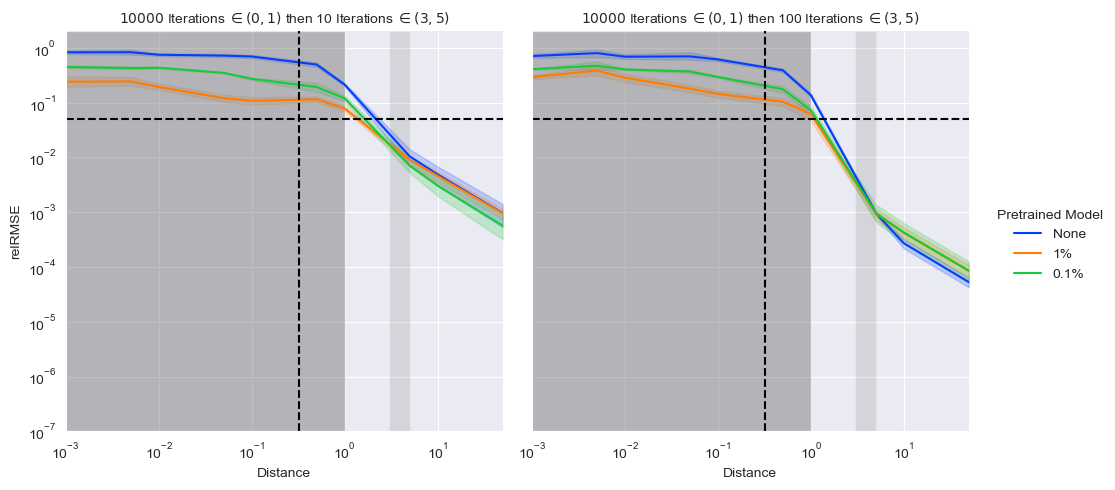

In [6]:
dfm = df.melt(["iterations", "pretrained_model"], str_altitudes, var_name="Distance", value_name=error_of_interest)
dfm["Distance"] = dfm["Distance"].apply(lambda x: float(x))
dfm[error_of_interest] = dfm[error_of_interest].apply(lambda x: float(x))

dfm.rename(columns={"iterations": "Fine-Tuning Iterations", "pretrained_model": "Pretrained Model"}, inplace=True)

g = sns.relplot(
    data=dfm, kind="line",
    col="Fine-Tuning Iterations",
    x="Distance", y=error_of_interest,
    hue="Pretrained Model", palette="bright", hue_order=["None", "1%", "0.1%"]
)
g.set(
    xlim=(0.001, 50.0), xscale='log', yscale='log', ylim=(1e-7, 2.0)
)

g.set_titles("$10 000$ Iterations $\in (0,1)$ then {col_name} Iterations $\in (3,5)$")

g.map(plt.axhline, y=0.05, ls='--', c='black', label="5%")
g.map(plt.axvline, x=one_km, ls='--', c='black', label="1 km")

for ax in g.axes[0,:]:
    ax.axvspan(0, 1.0, facecolor='gray', alpha=0.5)
    ax.axvspan(3.0, 5.0, facecolor='gray', alpha=0.2)

g.tight_layout()
save_path = os.path.join(output_directory, f"{sample}_{error_of_interest}_pretrain_iterations.png")
g.savefig(save_path, dpi=300)

In [7]:
df = pd.read_csv(input_csv_file)
ALTITUDES = ast.literal_eval(df.at[0, "validation_sampling_altitudes"])
str_altitudes = [str(x) for x in ALTITUDES]
df = df[df["noise"] != "['combined', 0.0, 0.146731, [0.000272, 0.0, 0.0]]"]
df = df[df["noise"] != "['combined', 0.0, 1.467314, [0.000272, 0.0, 0.0]]"]
df["sample_domain"] = df["sample_domain"].apply(lambda x: str(x))
df = df[(df["ground_truth"] == "polyhedral") & (df["resolution"] == "100%") & (df["noise"] == "['']") & (df["pretrained_model"] == "None")]

interesting_columns = ["sample", "pretrained_model", "seed", "ground_truth", "resolution", "sample_domain", "noise", "iterations", "integration_points"]
interesting_columns.extend([col for col in df if col.startswith(error_of_interest)])
interesting_columns = [x for x in interesting_columns if "@High Altitude" not in x and "@Low Altitude" not in x]

df = df[interesting_columns]

unit_conversion.convert_pandas_altitudes(df, ALTITUDES, convert_height=False, only_height=True)
df.drop(columns=["sample", "seed", "resolution", "noise", "ground_truth"], inplace=True)

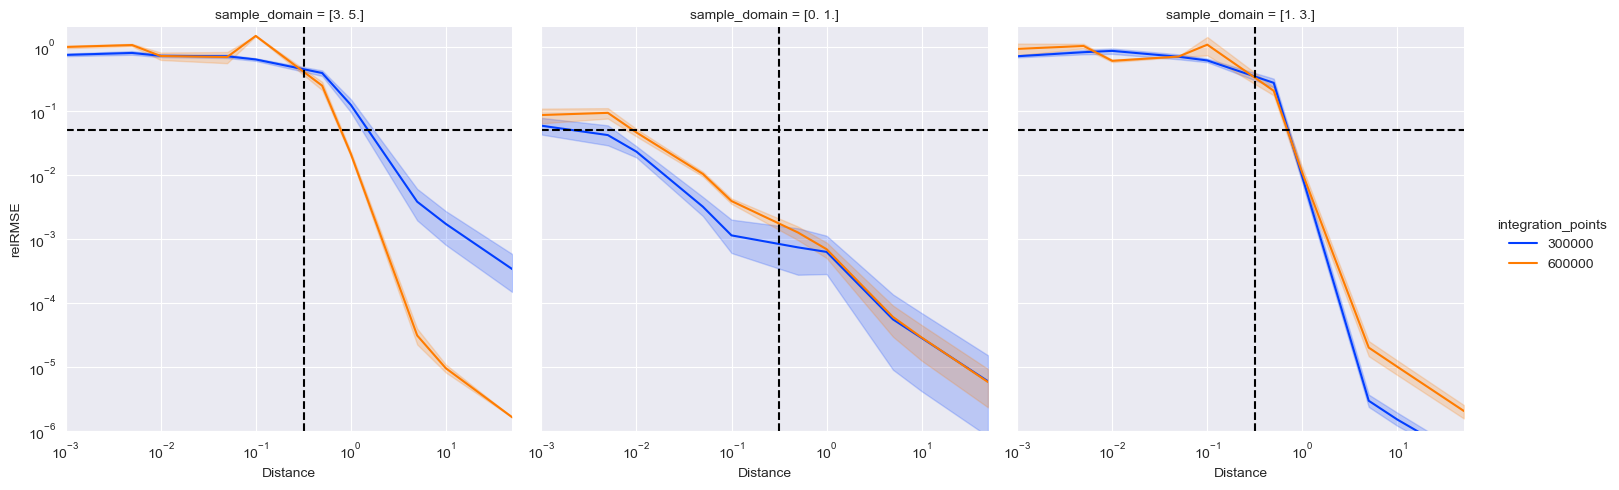

In [8]:
dfm = df.melt(["integration_points", "sample_domain"], str_altitudes, var_name="Distance", value_name=error_of_interest)
dfm["sample_domain"] = dfm["sample_domain"].apply(lambda x: str(x))
dfm["Distance"] = dfm["Distance"].apply(lambda x: float(x))
dfm[error_of_interest] = dfm[error_of_interest].apply(lambda x: float(x))

g = sns.relplot(
    data=dfm, kind="line",
    col="sample_domain",
    x="Distance", y=error_of_interest,
    hue="integration_points", palette="bright"
)

g.map(plt.axhline, y=0.05, ls='--', c='black', label="5%")
g.map(plt.axvline, x=one_km, ls='--', c='black', label="1 km")

g.set(
    xlim=(0.001, 50.0), xscale='log', yscale='log', ylim=(1e-6, 2.0)
)
g.tight_layout()
save_path = os.path.join(output_directory, f"{sample}_{error_of_interest}_integration_points.png")
g.savefig(save_path, dpi=300)

In [27]:
df = pd.read_csv(input_csv_file)
ALTITUDES = ast.literal_eval(df.at[0, "validation_sampling_altitudes"])
str_altitudes = [str(x) for x in ALTITUDES]
df = df[df["noise"] != "['combined', 0.0, 0.146731, [0.000272, 0.0, 0.0]]"]
df = df[df["noise"] != "['combined', 0.0, 1.467314, [0.000272, 0.0, 0.0]]"]
df["sample_domain"] = df["sample_domain"].apply(lambda x: str(x))
df = df[(df["iterations"] == 10000) & (df["pretrained_model"] == "None") & (df["resolution"] == "100%") & (df["integration_points"] == 300000) & (df["ground_truth"] == "polyhedral")]

interesting_columns = ["sample", "pretrained_model", "seed", "ground_truth", "resolution", "sample_domain", "noise", "iterations", "integration_points"]
interesting_columns.extend([col for col in df if col.startswith(error_of_interest)])
interesting_columns = [x for x in interesting_columns if "@High Altitude" not in x and "@Low Altitude" not in x]

df = df[interesting_columns]

unit_conversion.convert_pandas_altitudes(df, ALTITUDES, convert_height=False, only_height=True)
df.drop(columns=["sample", "seed", "resolution", "ground_truth", "integration_points", "iterations"], inplace=True)

In [28]:
df_copy = df.copy()
df_copy["sample_domain"] = df_copy["sample_domain"].apply(lambda x: str(x))
df_copy.groupby(["sample_domain", "noise"]).mean()

0.001     0.005  \
sample_domain noise                                                         
[0. 1.]       ['']                                     0.058438  0.041732   
              ['adaptive_gaussian_noise', 0.001]       0.046467  0.035678   
              ['adaptive_gaussian_noise', 0.01]        0.064643  0.046910   
              ['adaptive_gaussian_noise', 0.1]         0.109699  0.098376   
              ['constant_bias', [0.000272, 0.0, 0.0]]  0.044240  0.031410   
              ['gaussian', 0.0, 0.146731]              0.120246  0.140413   
              ['gaussian', 0.0, 1.467314]              0.303515  0.366143   
[1. 3.]       ['']                                     0.708069  0.818862   
              ['adaptive_gaussian_noise', 0.001]       0.727389  0.801816   
              ['adaptive_gaussian_noise', 0.01]        0.701842  0.775462   
              ['adaptive_gaussian_noise', 0.1]         0.706700  0.761070   
              ['constant_bias', [0.000272, 0.0, 0.0]]  0.714602  0.790547   
              ['gaussian', 0.0, 0.146731]              0.843610  0.887442   
              ['gaussian', 0.0, 1.467314]              1.123919  1.134727   
[3. 5.]       ['']                                     0.693520  0.758694   
              ['adaptive_gaussian_noise', 0.001]       0.738673  0.809487   
              ['adaptive_gaussian_noise', 0.01]        0.715175  0.800294   
              ['adaptive_gaussian_noise', 0.1]         0.686351  0.780606   
              ['constant_bias', [0.000272, 0.0, 0.0]]  0.716231  0.797233   
              ['gaussian', 0.0, 0.146731]              1.059019  1.084623   
              ['gaussian', 0.0, 1.467314]              1.342224  1.345036   

                                                           0.01      0.05  \
sample_domain noise                                                         
[0. 1.]       ['']                                     0.022997  0.003187   
              ['adaptive_gaussian_noise', 0.001]       0.021211  0.003693   
              ['adaptive_gaussian_noise', 0.01]        0.036683  0.008309   
              ['adaptive_gaussian_noise', 0.1]         0.073788  0.032798   
              ['constant_bias', [0.000272, 0.0, 0.0]]  0.019772  0.003120   
              ['gaussian', 0.0, 0.146731]              0.104462  0.043775   
              ['gaussian', 0.0, 1.467314]              0.332942  0.211091   
[1. 3.]       ['']                                     0.858633  0.695129   
              ['adaptive_gaussian_noise', 0.001]       0.770563  0.713315   
              ['adaptive_gaussian_noise', 0.01]        0.768409  0.662867   
              ['adaptive_gaussian_noise', 0.1]         0.791744  0.662737   
              ['constant_bias', [0.000272, 0.0, 0.0]]  0.757065  0.659073   
              ['gaussian', 0.0, 0.146731]              0.864752  0.757251   
              ['gaussian', 0.0, 1.467314]              1.122362  1.057735   
[3. 5.]       ['']                                     0.720466  0.702011   
              ['adaptive_gaussian_noise', 0.001]       0.802150  0.725109   
              ['adaptive_gaussian_noise', 0.01]        0.772518  0.680844   
              ['adaptive_gaussian_noise', 0.1]         0.782695  0.653174   
              ['constant_bias', [0.000272, 0.0, 0.0]]  0.771499  0.695474   
              ['gaussian', 0.0, 0.146731]              1.081415  1.017183   
              ['gaussian', 0.0, 1.467314]              1.339636  1.316166   

                                                            0.1       0.5  \
sample_domain noise                                                         
[0. 1.]       ['']                                     0.001138  0.000740   
              ['adaptive_gaussian_noise', 0.001]       0.001352  0.001051   
              ['adaptive_gaussian_noise', 0.01]        0.004312  0.002637   
              ['adaptive_gaussian_noise', 0.1]         0.021206  0.013328   
              ['constant_bias', [0.000272, 0.0, 0.0]

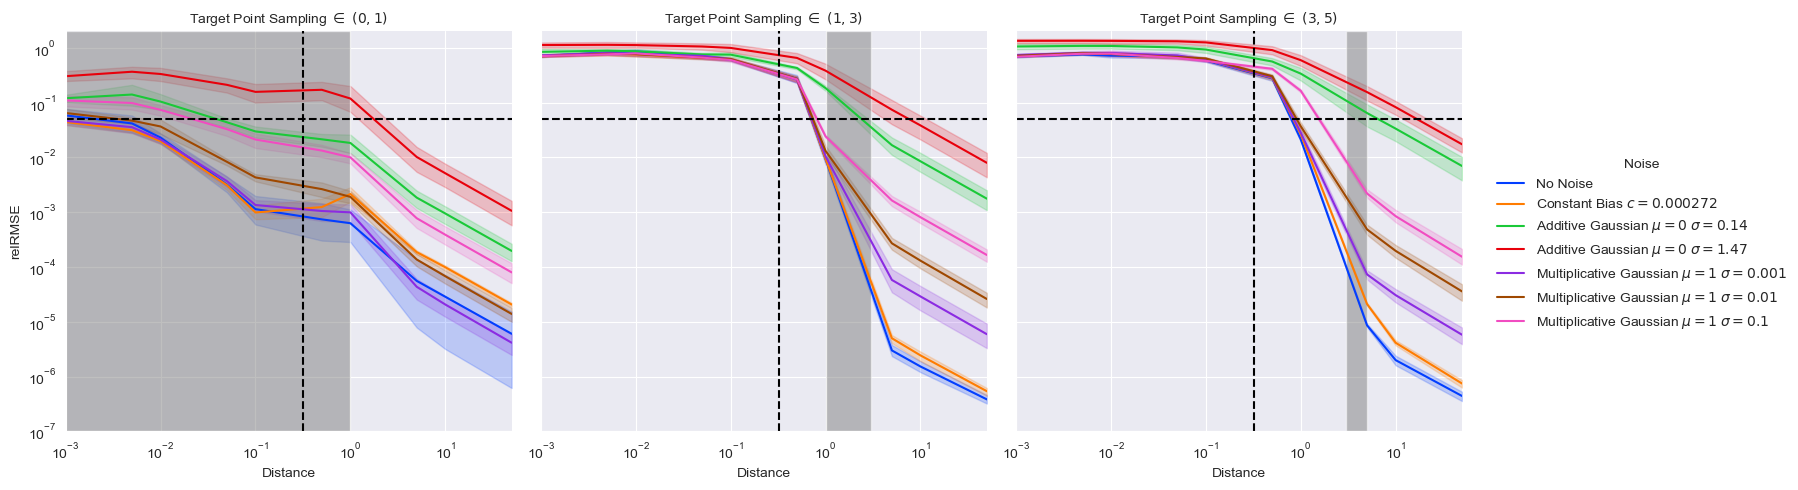

In [10]:
dfm = df.melt(["noise", "sample_domain"], str_altitudes, var_name="Distance", value_name=error_of_interest)
dfm["sample_domain"] = dfm["sample_domain"].apply(lambda x: str(x))
dfm["Distance"] = dfm["Distance"].apply(lambda x: float(x))
dfm[error_of_interest] = dfm[error_of_interest].apply(lambda x: float(x))

for key, replacement in noise_replacement.items():
    dfm["noise"].replace(key, replacement, inplace=True)

for key, replacement in sample_distance_replacement.items():
    dfm["sample_domain"].replace(key, replacement, inplace=True)

dfm.rename(columns={"sample_domain": "Sample Domain", "noise": "Noise"}, inplace=True)

g = sns.relplot(
    data=dfm, kind="line",
    col="Sample Domain", col_order=sample_distance_replacement.values(),
    x="Distance", y=error_of_interest,
    hue="Noise", palette="bright", hue_order=noise_replacement.values()
)
g.set(
    xlim=(0.001, 50.0), xscale='log', yscale='log', ylim=(1e-7, 2.0)
)

g.set_titles("Target Point Sampling $\in$ {col_name}")

g.map(plt.axhline, y=0.05, ls='--', c='black', label="5%")
g.map(plt.axvline, x=one_km, ls='--', c='black', label="1 km")

g.axes[0,0].axvspan(0, 1.0, facecolor='gray', alpha=0.5)
g.axes[0,1].axvspan(1.0, 3.0, facecolor='gray', alpha=0.5)
g.axes[0,2].axvspan(3.0, 5.0, facecolor='gray', alpha=0.5)

g.tight_layout()
save_path = os.path.join(output_directory, f"{sample}_{error_of_interest}_noise.png")
g.savefig(save_path, dpi=300)

In [108]:
dfm

,Noise,Sample Domain,Distance,relRMSE
0,Constant Bias $c = 0.000272$,"$(0, 1)$",0.001,0.036996
1,Additive Gaussian $\mu = 0 \; \sigma= 0.14$,"$(1, 3)$",0.001,0.842197
2,Additive Gaussian $\mu = 0 \; \sigma= 1.47$,"$(3, 5)$",0.001,1.066178
3,Additive Gaussian $\mu = 0 \; \sigma= 1.47$,"$(1, 3)$",0.001,1.199893
4,Constant Bias $c = 0.000272$,"$(1, 3)$",0.001,0.665508
...,...,...,...,...
2095,Multiplicative Gaussian $\mu = 1 \; \sigma= 0.01$,"$(1, 3)$",50.000,0.000017
2096,Multiplicative Gaussian $\mu = 1 \; \sigma= 0.01$,"$(3, 5)$",50.000,0.000028
2097,Multiplicative Gaussian $\mu = 1 \; \sigma= 0....,"$(0, 1)$",50.000,0.000004
2098,Multiplicative Gaussian $\mu = 1 \; \sigma= 0....,"$(1, 3)$",50.000,0.000006
